In [ ]:
from langchain_openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

In [ ]:
loader = DirectoryLoader('./', glob="./*.txt", loader_cls=TextLoader)
docs = loader.load()
len(docs)

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=100,
    chunk_overlap=10,
    length_function=len
)
new_docs = text_splitter.split_documents(documents=docs)
print(new_docs[0])
doc_strings = [doc.page_content for doc in new_docs]

In [ ]:
import time

start_time = time.perf_counter()
embedding_model_large = OpenAIEmbeddings(model="text-embedding-3-large")
vectors_large = embedding_model_large.embed_documents(doc_strings)
large_model_time = time.perf_counter() - start_time
print(f"Time taken for the large model: {large_model_time} seconds")

start_time = time.perf_counter()
embedding_model_small = OpenAIEmbeddings(model="text-embedding-3-small")
vectors_small = embedding_model_small.embed_documents(doc_strings)
small_model_time = time.perf_counter() - start_time
print(f"Time taken for the small model: {small_model_time} seconds")

start_time = time.perf_counter()
embedding_model_ada = OpenAIEmbeddings(model="text-embedding-ada-002")
vectors_ada = embedding_model_ada.embed_documents(doc_strings)
ada_model_time = time.perf_counter() - start_time
print(f"Time taken for the Ada model: {ada_model_time} seconds")


In [ ]:
QUERY = "do you offer vegetarian food?"

new_embedding_large = embedding_model_large.embed_documents([QUERY])[0]
new_embedding_small = embedding_model_small.embed_documents([QUERY])[0]
new_embedding_ada = embedding_model_ada.embed_documents([QUERY])[0]

print(len(new_embedding_large))
print(len(new_embedding_small))
print(len(new_embedding_ada))

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarities_large = [cosine_similarity([new_embedding_large], [vec])[0][0] for vec in vectors_large]
cosine_similarities_small = [cosine_similarity([new_embedding_small], [vec])[0][0] for vec in vectors_small]
cosine_similarities_ada = [cosine_similarity([new_embedding_ada], [vec])[0][0] for vec in vectors_ada]


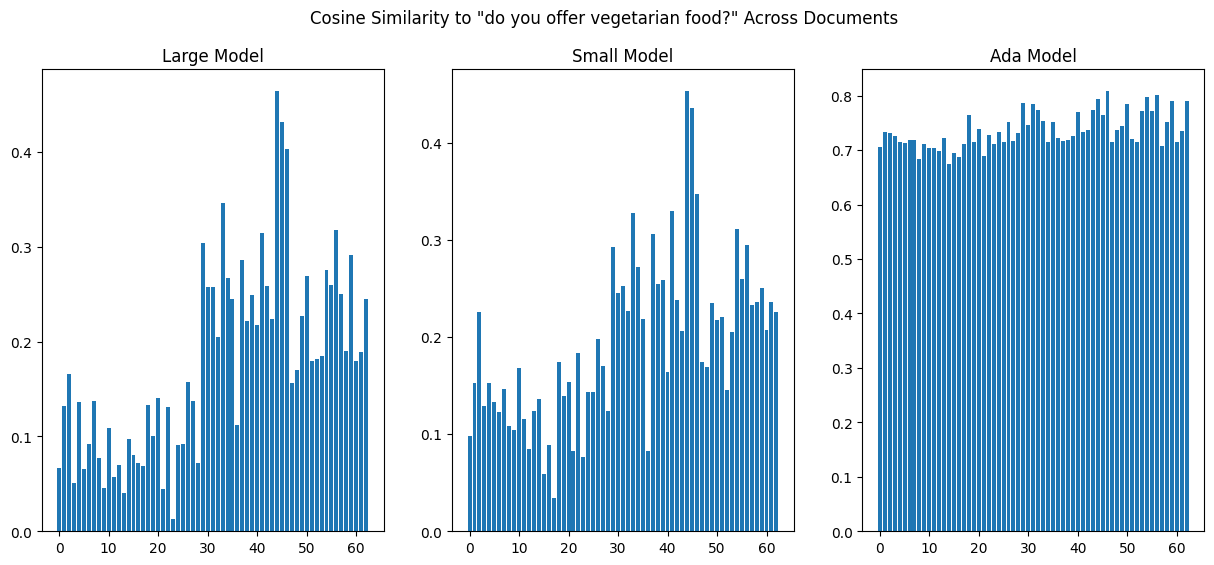

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
plt.bar(range(len(cosine_similarities_large)), cosine_similarities_large)
plt.title('Large Model')

plt.subplot(1, 3, 2)
plt.bar(range(len(cosine_similarities_small)), cosine_similarities_small)
plt.title('Small Model')

plt.subplot(1, 3, 3)
plt.bar(range(len(cosine_similarities_ada)), cosine_similarities_ada)
plt.title('Ada Model')

plt.suptitle('Cosine Similarity to "do you offer vegetarian food?" Across Documents')
plt.show()

In [ ]:
from langchain_community.vectorstores import Chroma

embedding_model_large = OpenAIEmbeddings(model="text-embedding-3-large", dimensions=1536) # Chroma does not support 3072


def retrieve_documents(embedding, new_docs, query, k=6):
    db = Chroma.from_documents(new_docs, embedding)
    retriever = db.as_retriever(search_kwargs={"k": k})
    return retriever.get_relevant_documents(query)

In [ ]:
docs_large = retrieve_documents(embedding_model_large, new_docs, QUERY)
docs_small = retrieve_documents(embedding_model_small, new_docs, QUERY)
docs_ada = retrieve_documents(embedding_model_ada, new_docs, QUERY)

In [ ]:
print("Dokumente für das große Modell:")
for doc in docs_large:
    print(doc)

In [ ]:
print("\nDokumente für das kleine Modell:")
for doc in docs_small:
    print(doc)

In [ ]:
print("\nDokumente für das Ada-Modell:")
for doc in docs_ada:
    print(doc)